2025-03-10 13:30:02,843 - __main__ - INFO - Config file root/config/priority_clustering_config.yaml not found, using default config
2025-03-10 13:30:02,844 - __main__ - INFO - Loading container data from root/input/container_data.csv


2025-03-10 13:30:02,913 - __main__ - INFO - Loading slotbook data from root/input/slotbook_data.csv
2025-03-10 13:30:02,944 - __main__ - WARNING - No slack_category column found in container data
2025-03-10 13:30:02,945 - __main__ - INFO - No slack categories found, generating synthetic priorities
2025-03-10 13:30:02,947 - __main__ - INFO - Processing 50 critical containers and 950 backlog containers
2025-03-10 13:30:02,948 - __main__ - INFO - Starting clustering with 50 critical containers and 950 backlog containers
2025-03-10 13:30:03,503 - __main__ - INFO - Cluster 0: 6 containers, centroid: 13.9
2025-03-10 13:30:03,505 - __main__ - INFO - Cluster 1: 6 containers, centroid: 17.2
2025-03-10 13:30:03,508 - __main__ - INFO - Cluster 2: 6 containers, centroid: 21.6
2025-03-10 13:30:03,510 - __main__ - INFO - Cluster 3: 6 containers, centroid: 27.3
2025-03-10 13:30:03,512 - __main__ - INFO - Cluster 4: 6 containers, centroid: 32.7
2025-03-10 13:30:03,513 - __main__ - INFO - Cluster 5: 6 

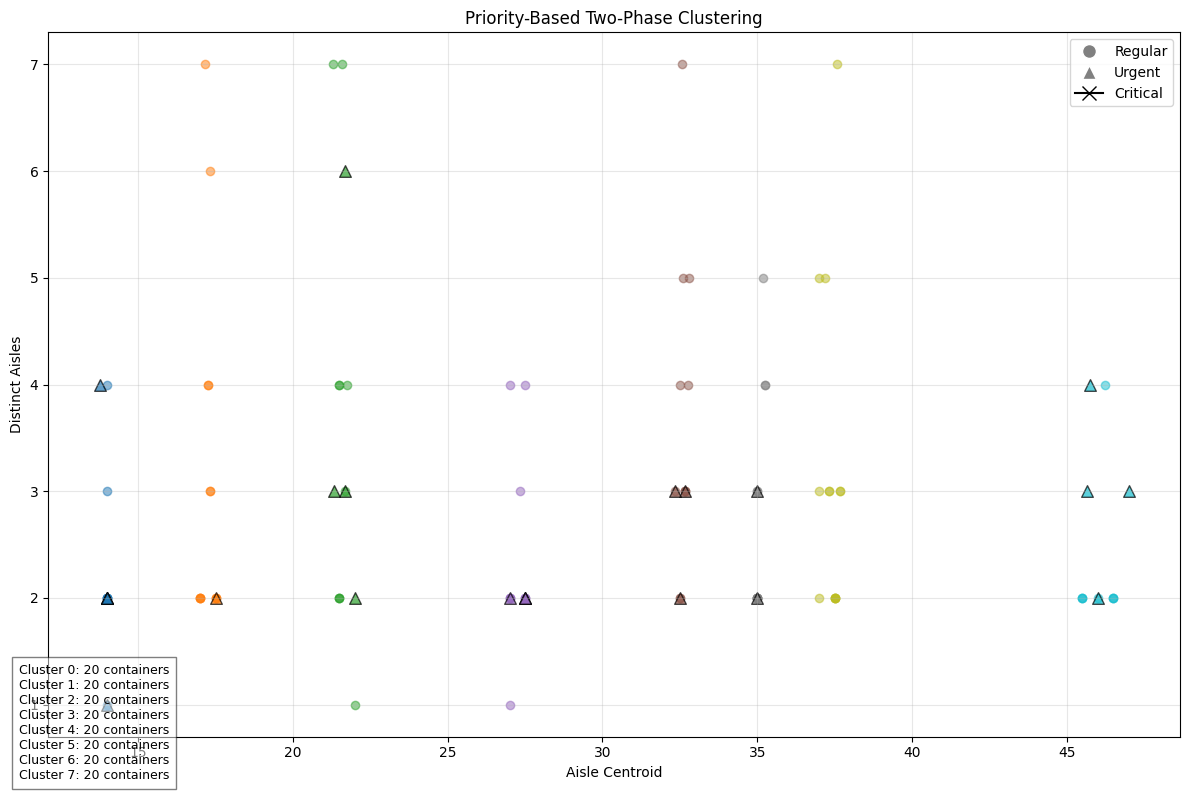

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import os
import yaml
import logging
from collections import defaultdict
from typing import Dict, List, Tuple, Set, Any
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# ----- CONFIGURATION FUNCTIONS -----

def load_config(config_path: str) -> Dict[str, Any]:
    """Load configuration from YAML file"""
    try:
        with open(config_path, 'r') as config_file:
            config = yaml.safe_load(config_file)
        return config
    except Exception as e:
        logger.error(f"Error loading configuration: {str(e)}")
        raise

# ----- CONTAINER ANALYSIS FUNCTIONS -----

def get_container_aisles(container_id: str, container_data: pd.DataFrame, 
                        sku_aisle_mapping: Dict[str, List[int]]) -> Set[int]:
    """
    Get optimized aisles required for a specific container, minimizing total aisles visited.
    Chooses the best aisle for multi-location SKUs by considering other SKUs in the container.
    """
    # Get all SKUs for this container
    container_skus = container_data[container_data['container_id'] == container_id]['item_number'].unique()

    # First, identify single-location SKUs - these must be visited
    must_visit_aisles = set()
    multi_location_skus = []

    for sku in container_skus:
        if sku in sku_aisle_mapping:
            aisles = sku_aisle_mapping[sku]
            if len(aisles) == 1:
                # Single location SKU - must visit this aisle
                must_visit_aisles.add(aisles[0])
            else:
                # Multi-location SKU - will optimize later
                multi_location_skus.append(sku)

    # For multi-location SKUs, choose aisles to minimize additional aisles
    for sku in multi_location_skus:
        aisles = sku_aisle_mapping[sku]
        
        # Check if any of the SKU's aisles are already in the must-visit set
        already_covered = [aisle for aisle in aisles if aisle in must_visit_aisles]
        
        if already_covered:
            # If one or more aisles are already covered, pick the first one
            best_aisle = already_covered[0]
        else:
            # Otherwise, find the aisle that minimizes the distance to the nearest must-visit aisle
            # If no must-visit aisles yet, choose the first available aisle
            if not must_visit_aisles:
                best_aisle = aisles[0]
            else:
                # Calculate "distance" to the nearest must-visit aisle for each option
                min_distance = float('inf')
                best_aisle = None
                
                for aisle in aisles:
                    # Find distance to closest must-visit aisle
                    closest_distance = min(abs(aisle - existing) for existing in must_visit_aisles)
                    
                    if closest_distance < min_distance:
                        min_distance = closest_distance
                        best_aisle = aisle
        
        # Add the best aisle to the must-visit set
        must_visit_aisles.add(best_aisle)

    return must_visit_aisles

def compute_container_features(container_id: str, container_data: pd.DataFrame, 
                              sku_aisle_mapping: Dict[str, List[int]]) -> Tuple[float, float, int]:
    """
    Compute feature vector for a container: (aisle_centroid, aisle_span, distinct_aisles)
    """
    # Get container aisles
    aisles = get_container_aisles(container_id, container_data, sku_aisle_mapping)
    
    if not aisles:
        return 0, 0, 0
    
    # Calculate aisle centroid and span
    centroid = sum(aisles) / len(aisles)
    span = max(aisles) - min(aisles) if len(aisles) > 1 else 0
    
    # Count distinct aisles
    distinct_aisles = len(aisles)
    
    return centroid, span, distinct_aisles

def preprocess_data(container_data: pd.DataFrame, slotbook_data: pd.DataFrame, 
                   use_distinct_aisles: bool = True,
                   centroid_weight: float = 0.5,
                   secondary_weight: float = 0.5) -> Tuple[List[str], np.ndarray, np.ndarray, Dict[str, List[int]]]:
    """
    Preprocess container data to create feature matrix for clustering.
    """
    logger.info("Preprocessing container data for clustering")
    
    # Build SKU-to-aisle mapping
    sku_aisle_mapping = {}
    for _, row in slotbook_data.iterrows():
        sku = row['item_number']
        aisle = row['aisle_sequence']
        if sku not in sku_aisle_mapping:
            sku_aisle_mapping[sku] = []
        sku_aisle_mapping[sku].append(aisle)
    
    # For each SKU, sort its aisles
    for sku in sku_aisle_mapping:
        sku_aisle_mapping[sku].sort()
    
    # Get all container IDs
    container_ids = container_data['container_id'].unique().tolist()
    
    # Compute features for each container
    feature_arrays = []
    raw_feature_arrays = []
    valid_containers = []
    container_features = {}
    
    for container_id in container_ids:
        # Compute container features
        centroid, span, distinct_aisles = compute_container_features(container_id, container_data, sku_aisle_mapping)
        container_features[container_id] = (centroid, span, distinct_aisles)
        
        # Skip containers with no aisle data
        if centroid == 0 and span == 0:
            continue
            
        # Choose secondary feature based on flag
        secondary_feature = distinct_aisles if use_distinct_aisles else span
        
        # Store raw features
        raw_feature_arrays.append([centroid, secondary_feature])
        
        # Store weighted features
        feature_arrays.append([
            centroid * centroid_weight,          # Aisle centroid 
            secondary_feature * secondary_weight # Secondary feature
        ])
        valid_containers.append(container_id)
    
    if not valid_containers:
        logger.warning("No valid containers found with aisle data")
        return [], np.array([]), np.array([]), sku_aisle_mapping
    
    # Create feature matrices
    feature_matrix = np.array(feature_arrays)
    raw_feature_matrix = np.array(raw_feature_arrays)
    
    # Log feature statistics
    logger.info(f"Processed {len(valid_containers)} valid containers")
    logger.info(f"Feature 1 (Centroid) - Mean: {np.mean(raw_feature_matrix[:, 0]):.2f}, "
               f"Min: {np.min(raw_feature_matrix[:, 0]):.2f}, "
               f"Max: {np.max(raw_feature_matrix[:, 0]):.2f}")
    logger.info(f"Feature 2 ({('Distinct Aisles' if use_distinct_aisles else 'Aisle Span')}) - "
               f"Mean: {np.mean(raw_feature_matrix[:, 1]):.2f}, "
               f"Min: {np.min(raw_feature_matrix[:, 1]):.2f}, "
               f"Max: {np.max(raw_feature_matrix[:, 1]):.2f}")
    
    # Normalize weighted features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_matrix)
    
    return valid_containers, normalized_features, raw_feature_matrix, sku_aisle_mapping

# ----- CLUSTERING FUNCTIONS -----

def find_best_matching_containers(backlog_containers: List[str], 
                                backlog_features: Dict[str, Tuple[float, float, int]],
                                cluster_centroid: float, 
                                count: int, 
                                already_assigned: Set[str] = None):
    """Find the best matching containers from backlog based on distance to centroid"""
    if already_assigned is None:
        already_assigned = set()
    
    # Calculate distance to cluster centroid
    container_distances = []
    for container_id in backlog_containers:
        if container_id in already_assigned:
            continue
            
        if container_id in backlog_features:
            centroid, _, _ = backlog_features[container_id]
            # Calculate distance to cluster centroid
            distance = abs(centroid - cluster_centroid)
            container_distances.append((container_id, distance))
    
    # Sort by distance (closest first)
    container_distances.sort(key=lambda x: x[1])
    
    # Return the best matches (up to count)
    return [c[0] for c in container_distances[:count]]

def cluster_critical_containers(critical_containers: List[str], 
                              container_data: pd.DataFrame, 
                              sku_aisle_mapping: Dict[str, List[int]],
                              num_clusters: int):
    """Cluster critical containers using a simple method based on centroid proximity"""
    
    # Compute features for all critical containers
    container_features = []
    for container_id in critical_containers:
        centroid, span, distinct_aisles = compute_container_features(container_id, container_data, sku_aisle_mapping)
        container_features.append((container_id, centroid, span, distinct_aisles))
    
    # Sort by centroid (primary sort key)
    container_features.sort(key=lambda x: x[1])
    
    # Simple clustering: divide the sorted list into approximately equal chunks
    clusters = defaultdict(list)
    containers_per_cluster = max(1, len(container_features) // num_clusters)
    for i, (container_id, _, _, _) in enumerate(container_features):
        cluster_id = min(i // containers_per_cluster, num_clusters - 1)
        clusters[cluster_id].append(container_id)
    
    return clusters

def cluster_priority_containers(critical_containers: List[str], 
                              backlog_containers: List[str], 
                              container_data: pd.DataFrame, 
                              slotbook_data: pd.DataFrame, 
                              max_total_containers: int = 1000,
                              containers_per_tour: int = 20, 
                              num_critical_clusters: int = 8):
    """
    Cluster with priority containers first, then fill with best matches from backlog.
    """
    logger.info(f"Starting clustering with {len(critical_containers)} critical containers and {len(backlog_containers)} backlog containers")
    
    # Build SKU-aisle mapping
    sku_aisle_mapping = {}
    for _, row in slotbook_data.iterrows():
        sku = row['item_number']
        aisle = row['aisle_sequence']
        if sku not in sku_aisle_mapping:
            sku_aisle_mapping[sku] = []
        sku_aisle_mapping[sku].append(aisle)
    
    # For each SKU, sort its aisles
    for sku in sku_aisle_mapping:
        sku_aisle_mapping[sku].sort()
    
    # 1. First cluster the critical containers
    critical_clusters = cluster_critical_containers(
        critical_containers,
        container_data,
        sku_aisle_mapping,
        num_critical_clusters
    )
    
    # 2. For each cluster, calculate centroid features
    cluster_centroids = {}
    for cluster_id, cluster_containers in critical_clusters.items():
        centroids = []
        spans = []
        distinct_aisles_counts = []
        
        for container_id in cluster_containers:
            # Get container features
            centroid, span, distinct_aisles = compute_container_features(
                container_id, container_data, sku_aisle_mapping
            )
            centroids.append(centroid)
            spans.append(span)
            distinct_aisles_counts.append(distinct_aisles)
        
        # Store average features for this cluster
        cluster_centroids[cluster_id] = {
            'centroid': np.mean(centroids) if centroids else 0,
            'span': np.mean(spans) if spans else 0,
            'distinct_aisles': np.mean(distinct_aisles_counts) if distinct_aisles_counts else 0,
            'container_count': len(cluster_containers)
        }
        
        logger.info(f"Cluster {cluster_id}: {len(cluster_containers)} containers, centroid: {cluster_centroids[cluster_id]['centroid']:.1f}")
    
    # 3. Calculate remaining capacity
    total_critical_containers = sum(len(containers) for containers in critical_clusters.values())
    remaining_capacity = max_total_containers - total_critical_containers
    logger.info(f"Critical containers: {total_critical_containers}, Remaining capacity: {remaining_capacity}")
    
    # 4. Calculate features for backlog containers
    backlog_features = {}
    for container_id in backlog_containers:
        backlog_features[container_id] = compute_container_features(
            container_id, container_data, sku_aisle_mapping
        )
    
    # 5. For each cluster, find best matching backlog containers
    final_clusters = {}
    backlog_assigned = set()
    
    # First pass - fill each cluster proportionally
    for cluster_id, containers in critical_clusters.items():
        cluster_size = len(containers)
        cluster_centroid = cluster_centroids[cluster_id]['centroid']
        
        # Calculate target count for this cluster
        cluster_proportion = cluster_size / total_critical_containers if total_critical_containers > 0 else 0
        target_additional = min(
            int(remaining_capacity * cluster_proportion),
            # Don't exceed capacity for max containers per tour
            (math.ceil(cluster_size / containers_per_tour) * containers_per_tour) - cluster_size
        )
        
        logger.info(f"Cluster {cluster_id}: Adding up to {target_additional} containers from backlog")
        
        # Find best matching containers for this cluster
        best_matches = find_best_matching_containers(
            backlog_containers, backlog_features, 
            cluster_centroid, target_additional, 
            already_assigned=backlog_assigned
        )
        
        # Add to final clusters
        final_clusters[cluster_id] = containers + best_matches
        backlog_assigned.update(best_matches)
        
        logger.info(f"  -> Added {len(best_matches)} containers, cluster now has {len(final_clusters[cluster_id])} containers")
    
    # 6. If we still have capacity and backlog containers left, add more
    remaining_capacity = max_total_containers - sum(len(containers) for containers in final_clusters.values())
    
    if remaining_capacity > 0:
        logger.info(f"Still have {remaining_capacity} capacity remaining, filling more...")
        
        # Sort clusters by current size
        sorted_clusters = sorted(
            final_clusters.items(), 
            key=lambda x: len(x[1]), 
            reverse=False  # Start with smallest clusters
        )
        
        # Fill remaining capacity by adding to each cluster
        for cluster_id, containers in sorted_clusters:
            if remaining_capacity <= 0:
                break
                
            cluster_centroid = cluster_centroids[cluster_id]['centroid']
            current_size = len(containers)
            
            # How many more can we add to this cluster
            space_in_cluster = (math.ceil(current_size / containers_per_tour) * containers_per_tour) - current_size
            to_add = min(space_in_cluster, remaining_capacity)
            
            if to_add > 0:
                logger.info(f"Cluster {cluster_id}: Adding {to_add} more containers")
                
                # Find best matching containers
                best_matches = find_best_matching_containers(
                    backlog_containers, backlog_features, 
                    cluster_centroid, to_add, 
                    already_assigned=backlog_assigned
                )
                
                # Add to final clusters
                final_clusters[cluster_id].extend(best_matches)
                backlog_assigned.update(best_matches)
                remaining_capacity -= len(best_matches)
                
                logger.info(f"  -> Added {len(best_matches)} containers, cluster now has {len(final_clusters[cluster_id])} containers")
    
    # Print final statistics
    total_assigned = sum(len(containers) for containers in final_clusters.values())
    logger.info(f"Final assignment: {total_assigned} containers assigned out of target {max_total_containers}")
    
    return final_clusters, backlog_features

# ----- VISUALIZATION FUNCTIONS -----

def plot_clusters(final_clusters: Dict[int, List[str]], 
                  container_features: Dict[str, Tuple[float, float, int]],
                  critical_containers: Set[str],
                  urgent_containers: Set[str] = None,
                  use_distinct_aisles: bool = True,
                  title: str = "Priority-Based Two-Phase Clustering",
                  output_path: str = "priority_clustering_results.png"):
    """Plot the final clusters, highlighting critical containers"""
    plt.figure(figsize=(12, 8))
    
    if urgent_containers is None:
        urgent_containers = set()
    
    # Create a colormap for different clusters
    colors = cm.get_cmap('tab10', len(final_clusters))
    
    # Prepare data for plotting
    for i, (cluster_id, containers) in enumerate(final_clusters.items()):
        # Extract features for plotting
        centroids = []
        secondary_values = []  # Either spans or distinct aisles
        
        # Track which points are critical
        critical_centroids = []
        critical_secondary = []
        
        # Track which points are urgent
        urgent_centroids = []
        urgent_secondary = []
        
        for container_id in containers:
            if container_id in container_features:
                centroid, span, distinct_aisles = container_features[container_id]
                secondary_value = distinct_aisles if use_distinct_aisles else span
                
                if container_id in critical_containers:
                    critical_centroids.append(centroid)
                    critical_secondary.append(secondary_value)
                elif container_id in urgent_containers:
                    urgent_centroids.append(centroid)
                    urgent_secondary.append(secondary_value)
                else:
                    centroids.append(centroid)
                    secondary_values.append(secondary_value)
        
        # Plot regular containers in this cluster
        plt.scatter(centroids, secondary_values, color=colors(i), alpha=0.5, label=f"Cluster {cluster_id}")
        
        # Plot urgent containers with triangles
        if urgent_centroids:
            plt.scatter(urgent_centroids, urgent_secondary, color=colors(i), marker='^', edgecolor='black', s=70, alpha=0.7)
        
        # Plot critical containers with X's
        if critical_centroids:
            plt.scatter(critical_centroids, critical_secondary, color=colors(i), marker='x', edgecolor='black', s=100, linewidth=2)
    
    # Add legend and labels
    plt.xlabel('Aisle Centroid')
    plt.ylabel('Distinct Aisles' if use_distinct_aisles else 'Aisle Span')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    # Add custom legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Regular'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=10, label='Urgent'),
        Line2D([0], [0], marker='x', color='black', markersize=10, label='Critical')
    ]
    
    # Add both legends: one for clusters, one for container types
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Show cluster info in a text box
    cluster_info = "\n".join([f"Cluster {cluster_id}: {len(containers)} containers" 
                              for cluster_id, containers in final_clusters.items()])
    plt.figtext(0.02, 0.02, cluster_info, fontsize=9, 
                bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    plt.tight_layout()
    
    # Save the figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        logger.info(f"Saved plot to {output_path}")
    
    return plt.gcf()  # Return the figure for displaying

def save_cluster_assignments(final_clusters: Dict[int, List[str]], 
                            output_path: str):
    """Save cluster assignments to CSV file"""
    # Prepare data
    data = []
    for cluster_id, containers in final_clusters.items():
        for container_id in containers:
            data.append({
                'container_id': container_id,
                'cluster_id': cluster_id
            })
    
    # Create dataframe and save
    df = pd.DataFrame(data)
    df.to_csv(output_path, index=False)
    logger.info(f"Saved cluster assignments to {output_path}")

def get_category_containers(container_data: pd.DataFrame) -> Tuple[Set[str], Set[str], Set[str]]:
    """Get containers by category (critical, urgent, safe)"""
    if 'slack_category' not in container_data.columns:
        logger.warning("No slack_category column found in container data")
        return set(), set(), set()
    
    # Get unique container-category pairs
    container_categories = container_data[['container_id', 'slack_category']].drop_duplicates()
    
    # Split by category
    critical = set(container_categories[container_categories['slack_category'] == 'Critical']['container_id'])
    urgent = set(container_categories[container_categories['slack_category'] == 'Urgent']['container_id'])
    safe = set(container_categories[container_categories['slack_category'] == 'Safe']['container_id'])
    
    return critical, urgent, safe

# ----- MAIN FUNCTION -----

def main():
    # Load and validate configuration
    config_path = 'root/config/priority_clustering_config.yaml'
    if not os.path.exists(config_path):
        logger.info(f"Config file {config_path} not found, using default config")
        config = {
            'input': {
                'container_data_path': 'root/input/container_data.csv',
                'slotbook_data_path': 'root/input/slotbook_data.csv'
            },
            'output': {
                'dir': 'root/output',
                'plot_filename': 'priority_clusters.png',
                'assignments_filename': 'cluster_assignments.csv'
            },
            'features': {
                'use_distinct_aisles': True,
                'centroid_weight': 0.5,
                'secondary_weight': 0.5
            },
            'clustering': {
                'max_total_containers': 1000,
                'containers_per_tour': 20,
                'num_critical_clusters': 8
            }
        }
    else:
        config = load_config(config_path)
    
    # Create output directory
    output_dir = config['output']['dir']
    os.makedirs(output_dir, exist_ok=True)
    
    # Set output paths
    plot_path = os.path.join(output_dir, config['output']['plot_filename'])
    assignments_path = os.path.join(output_dir, config['output']['assignments_filename'])
    
    try:
        # Load data
        container_data_path = config['input']['container_data_path']
        slotbook_data_path = config['input']['slotbook_data_path']
        
        logger.info(f"Loading container data from {container_data_path}")
        container_data = pd.read_csv(container_data_path)
        sampled_containers = container_data['container_id'].unique()[:1000]        
        container_data = container_data[container_data['container_id'].isin(sampled_containers)]
        
        logger.info(f"Loading slotbook data from {slotbook_data_path}")
        slotbook_data = pd.read_csv(slotbook_data_path)
        
        # Basic data validation
        required_container_cols = ['container_id', 'item_number']
        required_slotbook_cols = ['item_number', 'aisle_sequence']
        
        for col in required_container_cols:
            if col not in container_data.columns:
                raise ValueError(f"Container data missing required column: {col}")
        
        for col in required_slotbook_cols:
            if col not in slotbook_data.columns:
                raise ValueError(f"Slotbook data missing required column: {col}")
        
        # Preprocess data
        use_distinct_aisles = config['features']['use_distinct_aisles']
        centroid_weight = config['features']['centroid_weight']
        secondary_weight = config['features']['secondary_weight']
        
        # Get priority containers
        critical_containers, urgent_containers, _ = get_category_containers(container_data)
        
        # If no slack_category found, create synthetic categories based on percentage
        if not critical_containers and not urgent_containers:
            logger.info("No slack categories found, generating synthetic priorities")
            all_container_ids = container_data['container_id'].unique()
            total_containers = len(all_container_ids)
            
            # Use 10% critical, 20% urgent
            critical_count = int(total_containers * 0.05)
            urgent_count = int(total_containers * 0.20)
            
            # Randomly assign
            np.random.seed(42)  # For reproducibility
            critical_containers = set(np.random.choice(all_container_ids, size=critical_count, replace=False))
            
            remaining = [c for c in all_container_ids if c not in critical_containers]
            urgent_containers = set(np.random.choice(remaining, size=urgent_count, replace=False))
        
        # Get backlog containers (all non-critical)
        all_container_ids = set(container_data['container_id'].unique())
        backlog_containers = [c for c in all_container_ids if c not in critical_containers]
        
        logger.info(f"Processing {len(critical_containers)} critical containers and {len(backlog_containers)} backlog containers")
        
        # Run clustering
        max_total_containers = config['clustering']['max_total_containers']
        containers_per_tour = config['clustering']['containers_per_tour']
        num_critical_clusters = config['clustering']['num_critical_clusters']
        
        final_clusters, container_features = cluster_priority_containers(
            list(critical_containers),
            backlog_containers,
            container_data,
            slotbook_data,
            max_total_containers=max_total_containers,
            containers_per_tour=containers_per_tour,
            num_critical_clusters=num_critical_clusters
        )
        
        # Plot results
        plot_clusters(
            final_clusters, 
            container_features, 
            critical_containers, 
            urgent_containers,
            use_distinct_aisles=use_distinct_aisles,
            output_path=plot_path
        )
        
        # Save assignments
        save_cluster_assignments(final_clusters, assignments_path)
        
        logger.info("Clustering completed successfully")
    
    except Exception as e:
        logger.error(f"Error during clustering: {str(e)}", exc_info=True)
        raise

if __name__ == "__main__":
    main()


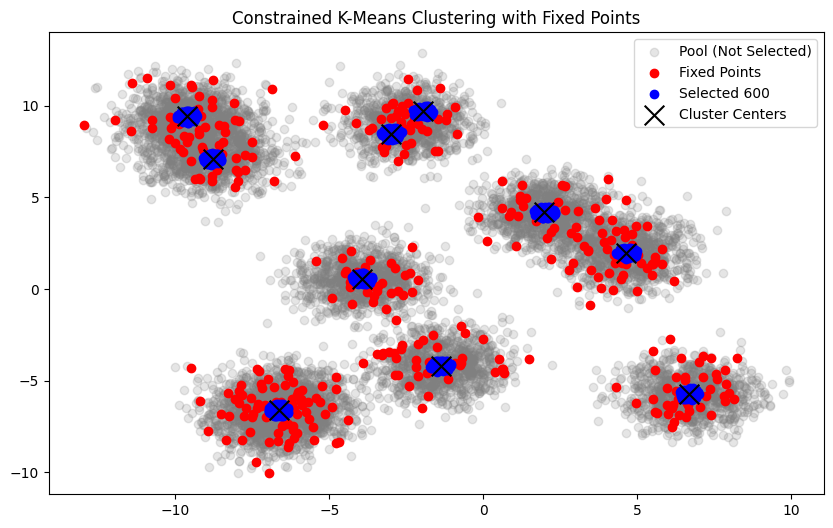

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Step 1: Generate synthetic data
n_fixed = 400  # Fixed data points
n_pool = 10000  # Pool of data points
n_select = 600  # Number of points to select
n_clusters = 10  # Number of clusters

# Generate a dataset with clear cluster structure
X, y = make_blobs(n_samples=n_fixed + n_pool, centers=n_clusters, cluster_std=1.0, random_state=42)

# Split into fixed points and pool
X_fixed = X[:n_fixed]  # First 400 points are fixed
X_pool = X[n_fixed:]   # Remaining 10,000 points are the pool

# Step 2: Constrained K-Means
kmeans = KMeans(n_clusters=n_clusters, init=X_fixed[:n_clusters], n_init=1, random_state=42)
kmeans.fit(np.vstack((X_fixed, X_pool)))  # Fit on the entire dataset

# Step 3: Select best 600 points
distances = kmeans.transform(X_pool)  # Get distances to cluster centers
best_600_indices = np.argsort(np.min(distances, axis=1))[:n_select]  # Select 600 closest points
X_selected = X_pool[best_600_indices]

# Step 4: Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_pool[:, 0], X_pool[:, 1], c='gray', alpha=0.2, label="Pool (Not Selected)")
plt.scatter(X_fixed[:, 0], X_fixed[:, 1], c='red', label="Fixed Points")
plt.scatter(X_selected[:, 0], X_selected[:, 1], c='blue', label="Selected 600")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='x', s=200, label="Cluster Centers")
plt.legend()
plt.title("Constrained K-Means Clustering with Fixed Points")
plt.show()
